In [41]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import math
from collections import namedtuple, deque
import random
from torch import nn
from torch import optim
from torch.functional import F
import matplotlib.pyplot as plt
import matplotlib
from itertools import count
import os

* Constants

In [42]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.6
EPS_END = 0.1
EPS_DECAY = 1000
TAU = 0.005
LR = 0.01
steps_done = 0
best_invalid = 50


* Print function

In [43]:
import csv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def write_to_file(state,action,reward,expected):
  data = [(torch.tensor(state,device=device), torch.tensor(action,device=device), torch.tensor(reward,device=device), torch.tensor(expected,device=device))
           for state, action,reward,expected in zip(state,action,reward,expected)]

  file_path = "data.txt"

  with open(file_path, 'w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(["State", "Action","reward","expected"])
      writer.writerows(data)


In [44]:
# matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [45]:
def plot_invalid_turn_numbers(invalid_list, turn_numbers, show_result=False):
    plt.figure(1)
    
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')

    plt.xlabel('Training Step')
    plt.ylabel('Invalids', color='tab:blue')
    plt.plot(invalid_list, color='tab:blue')

    if turn_numbers:
        plt.twinx()
        plt.ylabel('Turn Numbers', color='tab:red')
        plt.plot(turn_numbers, color='tab:red')

    plt.pause(0.001)

    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [46]:
class TicTacToeEnv(gym.Env):
    def __init__(self):
        super(TicTacToeEnv, self).__init__()
        self.board = torch.zeros((3, 3), dtype=torch.float64)  # Initialize an empty 3x3 board
        self.observation_space = spaces.MultiBinary(9)  # 3x3 board, each cell is binary
        self.action_space = spaces.Discrete(9)  

    def reset(self):
        self.board = torch.zeros((3, 3), dtype=torch.float64)
        return self.board.flatten()

    def select_action(self,state,player):
        global steps_done
        new_state=state
        if player.sign == -1:
            new_state = torch.where(state == 1, -1, torch.where(state == -1, 1, state)).clone().detach()
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1
        new_state = torch.tensor(new_state, dtype=torch.float32, device=device).clone().detach()
        
        if sample > eps_threshold:
            with torch.no_grad():
                q_values = player.policy_net(new_state)
                action = q_values.max(1)[1]
                return action
        else:
            return torch.tensor([self.action_space.sample()], device=device, dtype=torch.int32)
    
    def step(self, action, player):
        row, col = divmod(action, 3)
        
        if self.board[row, col] != 0:
            return (
                torch.tensor(self.board.flatten(), dtype=torch.float64,requires_grad=True).clone().detach(),
                -10,  # Negative reward for an invalid move
                True,
                "Invalid move"
            )
        self.board[row, col] = player.sign
        done, reward, Info = self.check_game(player)
        return torch.tensor(self.board.flatten(), dtype=torch.float64,requires_grad=True).clone().detach(), reward, done, Info


    def check_game(self,player):
        board = self.board
        new_board = board
        if player.sign == -1:
            new_board = torch.where(board == 1, -1, torch.where(board == -1, 1, board))
        for i in range(3):
            if all(new_board[i, :] == 1) or all(new_board[:, i] == 1):
                return True, 1 , "Win"
        if torch.all(torch.diag(new_board) == 1) or torch.all(torch.diag(torch.fliplr(new_board)) == 1):
            return True, 1, "Win"
        if torch.all(board != 0):
            print("draw")
            return True, 0 ,"Draw"
        return False, 0 , "Game ongoing"
    

    def train(self, player1, player2):
        if torch.cuda.is_available():
            num_episodes = 12000
        else:
            num_episodes = 600
        # losses_list = []
        # best_invalid = 100
        invalid_list = []
        turn_numbers = []
        total_turn_number = 0
        for i_episode in range(num_episodes):
            # Randomly choose the starting player for this episode
            starting_player = random.choice([player1, player2])
            players = [starting_player, player1 if starting_player == player2 else player2]
            if i_episode % 100 == 0:
                lowest_invalid_player = min(players, key=lambda player: player.invalid)
                for player in players:
                    if player.invalid > lowest_invalid_player.invalid:
                        player.policy_net.load_state_dict(lowest_invalid_player.policy_net.state_dict())
                if lowest_invalid_player.invalid < best_invalid:
                    best_policy_net_state_dict = lowest_invalid_player.policy_net.state_dict()
                    # Save the best policy network's state dictionary to a file
                    torch.save(best_policy_net_state_dict, 'best_policy_net.pth')
                plot_invalid_turn_numbers(invalid_list,turn_numbers)

            board1 = self.reset()
            state1 = torch.tensor(board1, dtype=torch.float32, device=device).unsqueeze(0)
            for t in count():
                # for item in player.memory:
                #     print("memoryitem:",item)
                player = players[t % 2]  # Alternates the players
                action = self.select_action(state1, player)
                observation, reward, done, Info = self.step(action.item(), player)
                next_state = None
                if done:
                    if Info == "Win":
                        player.win += 1
                    if Info == "Invalid move":
                        player.invalid += 1
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
                    # print("next",next_state)
                reward = torch.tensor([reward], device=device).clone().detach()
                # print("state:",state1)
                # print("action:",action)
                # print("next_state:",next_state)
                # print("reward:",reward)
                player.push(state1, action, next_state, reward)
                state1 = next_state
                player.optimize_model()
                target_net_state_dict = player.target_net.state_dict()
                policy_net_state_dict = player.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
                player.target_net.load_state_dict(target_net_state_dict)
                if done:
                    # losses_list = [player1.losses, player2.losses]
                    # plot_loss(losses_list)
                    total_turn_number += t
                    if i_episode % 100 == 0:
                            average_turn = total_turn_number / 100
                            turn_numbers.append(average_turn)
                            invalid_list.append([player1.invalid, player2.invalid])
                            plot_invalid_turn_numbers(invalid_list,turn_numbers)
                            player1.win = 0
                            player2.win = 0
                            player1.invalid = 0
                            player2.invalid = 0
                            total_turn_number = 0
                            # print("turn_number:",average_turn)
                    break

        print('Complete')
        # Plot the losses
        plot_invalid_turn_numbers(invalid_list,turn_numbers, show_result=True)
        plt.ioff()
        plt.show()
        

In [47]:
class DQN(nn.Module):
  def __init__(self, n_observations, n_actions):
      super(DQN, self).__init__()
      self.layer1 = nn.Linear(n_observations, 32)
      self.layer2 = nn.Linear(32, 32)
      self.layer3 = nn.Linear(32, n_actions)

  def forward(self, x):
      x = F.relu(self.layer1(x))
      x = F.relu(self.layer2(x))
      return self.layer3(x)

best_DQN = DQN(9, 9).to(device)


In [48]:

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class Player(object):
    def __init__(self, capacity,sign,opponent=None):
        self.memory = deque([], maxlen=capacity)
        self.losses = []
        self.sign = sign
        self.policy_net = best_DQN
        self.target_net = best_DQN
        self.win = 0
        self.invalid = 0
        self.opponent = opponent
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
        self.criterion = nn.SmoothL1Loss()
    def print_memory_size(self):
        print("player:",self.sign,"memory_size:",len(self.memory))

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        # randomly choose some samples from memory
        transitions = self.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool).clone().detach()
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)
        
        # classify the data of each type
        state_batch = torch.cat([s.requires_grad_(True) for s in batch.state]).to(device)
        action_batch = torch.cat([a.requires_grad_(True) for a in batch.action]).to(device)
        reward_batch = torch.cat([r.requires_grad_(True) for r in batch.reward]).to(device)
        state_batch = state_batch.view(-1, 9)


        # convert indices to one-hot encoded vectors
        one_hot = torch.zeros((len(action_batch), 9), device=device)
        one_hot = one_hot.scatter(1, action_batch.unsqueeze(1).long(), 1)
        one_hot.requires_grad = True
        
        state_action_values = self.policy_net(state_batch).gather(1, one_hot.to(torch.int64)).requires_grad_(True)

        non_final_next_states = non_final_next_states.view(-1, 9)
        next_state_values = torch.zeros(BATCH_SIZE, device=device)

        with torch.no_grad():
            # predict the non_final next states's values
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
        
        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        # self.losses.append(loss.item())
        self.optimizer.step()

    def push(self, state, action, next_state, reward):
        """Save a transition"""
        # Convert values to float32 tensors
        state = torch.tensor(state, dtype=torch.float32)
        action = torch.tensor(action, dtype=torch.float32)
        if next_state != None:
            next_state = torch.tensor(next_state, dtype=torch.float32)
        reward = torch.tensor(reward, dtype=torch.float32)

        if len(self.memory) >= self.memory.maxlen:
            self.memory.popleft()  # Remove the oldest transition
        self.memory.append(Transition(state, action, next_state, reward))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Complete


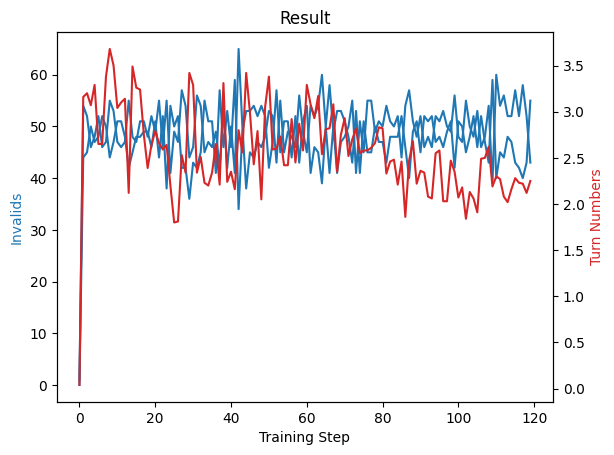

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [49]:
player1 = Player(10000,1)
player2 = Player(10000,-1,player1)
player1.opponent = player2

game = TicTacToeEnv()
game.train(player1,player2)


